In [1]:
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import random
import pickle

# --- 1. Import Custom Function Modules ---
try:
    import sampler_functions as sf
    import outlier_functions as oef
    import analysis as an
except ImportError:
    print("Error: Make sure 'sampler_functions.py', 'outlier_functions.py', and 'analysis_functions.py' are in the same directory.")

highhigh = 0.9975
highlow = 0.995
lowhigh = 0.005
lowlow = 0.0025

In [2]:
params = {
    'm': 10,
    'k': 5,
    'mu_true': 10.0,
    'num_iterations_T': 30000,
    'prior_mean': 0.0,
    'prior_std': 20.0,
    'proposal_std_mu': 0.9,
}
# Add z_domain to params, as it depends on k
z_domain_half_width = 1 / (2 * np.sqrt(params['k']))
params['z_domain'] = (-z_domain_half_width, z_domain_half_width)


In [3]:
results_path = os.path.join(
    "results_outlier_multiple",
    f"k_{params['k']}_m_{params['m']}"
)
os.makedirs(results_path, exist_ok=True)
print(f"\nResults will be saved in: '{results_path}'")
print("-" * 30)




Results will be saved in: 'results_outlier_multiple/k_5_m_10'
------------------------------


In [4]:
import random
import numpy as np

# Define a list of 10 seeds for reproducibility
seeds = [42, 123, 987, 654, 321, 555, 767, 888, 990, 111]
# A dictionary to store the results from all runs
all_runs_datasets = {}

# Loop through each seed to run the experiment 10 times
for seed in seeds:
    print(f"\n{'='*20} RUNNING EXPERIMENT WITH SEED: {seed} {'='*20}")
    # Set the seed for both numpy and random for full reproducibility
    np.random.seed(seed)
    random.seed(seed)

    # --- Generating Clean, Centered Dataset ---
    print("--- Generating Clean, Centered Dataset ---")
    x1_clean = sf.generate_clean_dataset_centered(params)
    print("Clean dataset generated successfully.")
    print(f"Verified MLE of clean dataset: {sf.get_mle(x1_clean, params):.6f}\n")

    # --- Generating 5 Sequential Outlier Datasets ---
    print("\n--- Generating 5 Sequential Outlier Datasets ---")
    outlier_datasets = []
    num_outlier_sets_to_generate = 5

    # Start with the clean dataset as the base for the first modification
    current_dataset = x1_clean.copy() 
    # Keep track of indices that are still "clean" and can be modified
    available_indices = list(range(params['m']))

    for i in range(num_outlier_sets_to_generate):
        # Check if we have enough clean points left to form a pair
        if len(available_indices) < 2:
            print(f"Not enough available indices to continue. Generated {i} outlier sets.")
            break

        print(f"--- Generating Outlier Set {i+1} (Total non-clean points: {(i+1)*2}) ---")
        
        # Randomly select two available indices to form the new pair
        indices_to_update = tuple(random.sample(available_indices, 2))
        idx1, idx2 = indices_to_update
        
        # Generate the next outlier dataset based on the CURRENT one
        x_outlier = sf.generate_constrained_outlier_pair(
            clean_dataset=current_dataset,
            indices=indices_to_update,
            mu_star=params['mu_true'],
            k=params['k'],
            params=params,
            highhigh=highhigh,
            highlow=highlow,
            lowhigh=lowhigh,
            lowlow=lowlow
        )
        
        if x_outlier is not None:
            # Add the new dataset to our list
            outlier_datasets.append(x_outlier)
            
            original_val1 = current_dataset[idx1]
            original_val2 = current_dataset[idx2]
            new_val1 = x_outlier[idx1]
            new_val2 = x_outlier[idx2]
            print(f"  Modifying indices: ({idx1}, {idx2})")
            print(f"  Original values: x[{idx1}]={original_val1:.2f}, x[{idx2}]={original_val2:.2f}")
            print(f"  New values:      x[{idx1}]={new_val1:.2f}, x[{idx2}]={new_val2:.2f}")
            
            score_at_mu_true = sf.mle_score(params['mu_true'], x_outlier, params['k'])
            print(f"  Score at mu_true={params['mu_true']:.1f}: {score_at_mu_true:.6e}\n")

            # Update the current dataset for the next iteration
            current_dataset = x_outlier.copy()
            
            # Remove the used indices from the available pool
            available_indices.remove(idx1)
            available_indices.remove(idx2)
        else:
            print(f"Failed to generate a valid pair for indices ({idx1}, {idx2}). Stopping generation.")
            break
            
    # Store the results for the current seed
    all_runs_datasets[seed] = {
        'clean': x1_clean,
        'outliers': outlier_datasets
    }
    print(f"\nSuccessfully generated {len(outlier_datasets)} sequential outlier datasets for seed {seed}.")

print(f"\n{'='*20} ALL 10 RUNS COMPLETED {'='*20}")


==================== RUNNING EXPERIMENT WITH SEED: 42 ====================
--- Generating Clean, Centered Dataset ---
Clean dataset generated successfully.
Verified MLE of clean dataset: 10.000000


--- Generating 5 Sequential Outlier Datasets ---
--- Generating Outlier Set 1 (Total non-clean points: 2) ---
  Modifying indices: (1, 0)
  Original values: x[1]=10.82, x[0]=10.77
  New values:      x[1]=14.69, x[0]=10.57
  Score at mu_true=10.0: 3.053113e-16

--- Generating Outlier Set 2 (Total non-clean points: 4) ---
  Modifying indices: (6, 3)
  Original values: x[6]=9.63, x[3]=9.64
  New values:      x[6]=5.47, x[3]=10.18
  Score at mu_true=10.0: 2.498002e-16

--- Generating Outlier Set 3 (Total non-clean points: 6) ---
  Modifying indices: (4, 9)
  Original values: x[4]=9.72, x[9]=10.68
  New values:      x[4]=14.53, x[9]=9.43
  Score at mu_true=10.0: 2.914335e-16

--- Generating Outlier Set 4 (Total non-clean points: 8) ---
  Modifying indices: (2, 7)
  Original values: x[2]=9.65, x

In [5]:
for seed in all_runs_datasets:
    print(f"Seed {seed}: {len(all_runs_datasets[seed]['outliers'])} outlier datasets")

Seed 42: 5 outlier datasets
Seed 123: 5 outlier datasets
Seed 987: 5 outlier datasets
Seed 654: 5 outlier datasets
Seed 321: 5 outlier datasets
Seed 555: 5 outlier datasets
Seed 767: 5 outlier datasets
Seed 888: 5 outlier datasets
Seed 990: 5 outlier datasets
Seed 111: 5 outlier datasets



--- Visualizing Aggregated Datasets From All Runs ---


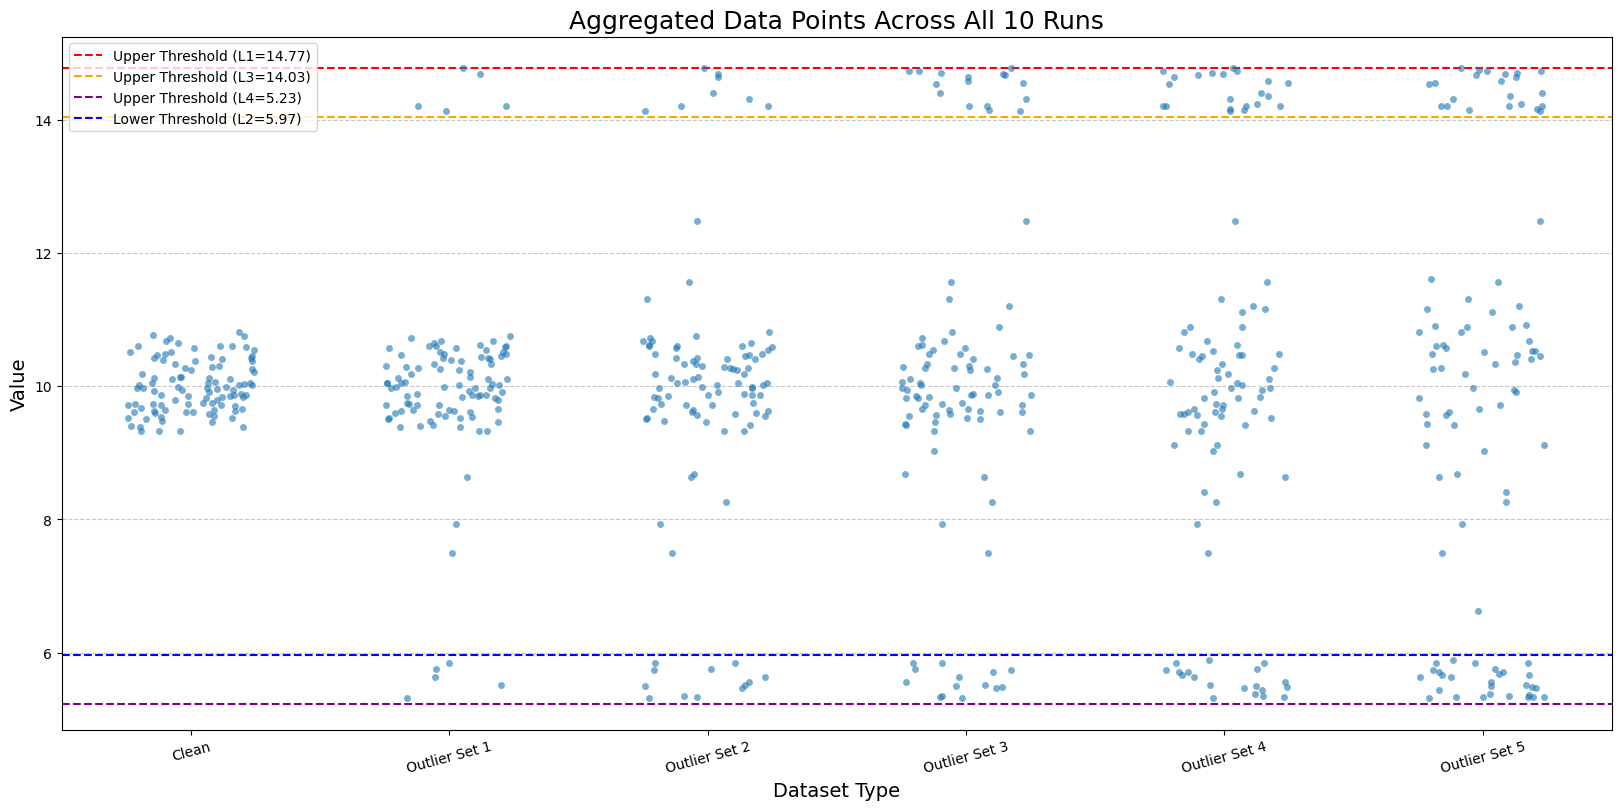

In [6]:
an.plot_all_runs_comparison(
    all_runs_datasets=all_runs_datasets,
    params=params,
    save_path=None,
    highhigh=highhigh,
    highlow=highlow,
    lowhigh=lowhigh,
    lowlow=lowlow
)

In [7]:
# --- 4. Compute or Load Benchmark Data ---
print("\n--- Loading/Computing Benchmark Data for p(μ̂ | μ=0) ---")

# Define the path where the results will be stored
# This path should already be defined in your script
# For example: results_path = "results_outlier_new"
# os.makedirs(results_path, exist_ok=True) 

results_path = "results_outlier_new"
# --- MODIFIED SECTION ---
# Create a filename that is specific to the value of k
k_value = params['k']
mle_samples_filename = f"benchmark_mle_samples_k_{k_value}.pkl"
mle_samples_save_path = os.path.join(results_path, mle_samples_filename)
# --- END OF MODIFIED SECTION ---

# Check if the file with the raw data for this specific k already exists
if os.path.exists(mle_samples_save_path):
    # If it exists, load the pre-computed samples
    print(f"Loading pre-computed benchmark samples from: {mle_samples_save_path}")
    with open(mle_samples_save_path, 'rb') as f:
        mle_samples = pickle.load(f)
else:
    # If it doesn't exist, run the expensive simulation using the new function
    print(f"No pre-computed samples found for k={k_value}. Running simulation...")
    mle_samples = sf.compute_benchmark_mle_samples(params, num_simulations=50000)
    
    # Save the newly computed samples for future runs
    with open(mle_samples_save_path, 'wb') as f:
        pickle.dump(mle_samples, f)
    print(f"Benchmark samples computed and saved to: {mle_samples_save_path}")

# --- Create the KDE object from the loaded/computed samples ---
print("\nBuilding Benchmark KDE from samples...")
kde_0 = stats.gaussian_kde(mle_samples)
print("Benchmark KDE is ready.")



--- Loading/Computing Benchmark Data for p(μ̂ | μ=0) ---
Loading pre-computed benchmark samples from: results_outlier_new/benchmark_mle_samples_k_5.pkl

Building Benchmark KDE from samples...
Benchmark KDE is ready.


In [8]:
# --- Calculate Benchmark Posterior using the loaded/computed KDE ---
print("\n--- Calculating Benchmark Posterior ---")
mu_grid = np.linspace(params['mu_true'] - 8, params['mu_true'] + 8, 1000)
# The likelihood p(μ̂ | μ) is equivalent to p(μ̂ - μ | 0).
likelihood_kde = kde_0.pdf(params['mu_true'] - mu_grid)
prior_on_grid = stats.norm.pdf(mu_grid, loc=params['prior_mean'], scale=params['prior_std'])
unnormalized_posterior_kde = likelihood_kde * prior_on_grid
area = np.trapz(unnormalized_posterior_kde, mu_grid)
benchmark_posterior = unnormalized_posterior_kde / area
print("Benchmark posterior calculated successfully.")



--- Calculating Benchmark Posterior ---
Benchmark posterior calculated successfully.


/var/folders/q7/v7x9p15j5mxcfyv0j1hwnkqr0000gn/T/ipykernel_57009/1875981414.py:8: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(unnormalized_posterior_kde, mu_grid)


In [9]:
# --- 5. Compute True Analytical Posteriors for All Runs ---
print("\n--- Generating True Analytical Posterior for Each Dataset in Each Run ---")

# This dictionary will store the results for all 10 runs
# Structure: {seed: [posterior_clean, posterior_outlier1, ...]}
all_runs_posteriors = {}
# The mu_grid will be the same for all, so we only need to store it once
mu_grid_main = None 

# Loop through the dictionary containing the data from all seeds
for seed, run_data in all_runs_datasets.items():
    print(f"\n--- Processing Run for Seed: {seed} ---")
    
    # This list will store the posteriors for the current seed's run
    posteriors_for_this_run = []
    
    # Combine the clean and outlier datasets for this run
    all_datasets_for_this_run = [run_data['clean']] + run_data['outliers']
    
    for i, dataset in enumerate(all_datasets_for_this_run):
        if i == 0:
            print(f"  Calculating analytical posterior for Clean Dataset...")
        else:
            print(f"  Calculating analytical posterior for Outlier Set {i}...")
        
        # Call the new function from your sf file
        mu_grid, true_posterior = sf.calculate_true_analytical_posterior(dataset, params)
        
        posteriors_for_this_run.append(true_posterior)
        if mu_grid_main is None:
            mu_grid_main = mu_grid
            
    # Store the list of posteriors for the current seed
    all_runs_posteriors[seed] = posteriors_for_this_run

print("\nAll analytical posteriors for all 10 runs calculated successfully.")




--- Generating True Analytical Posterior for Each Dataset in Each Run ---

--- Processing Run for Seed: 42 ---
  Calculating analytical posterior for Clean Dataset...
  Calculating analytical posterior for Outlier Set 1...
  Calculating analytical posterior for Outlier Set 2...
  Calculating analytical posterior for Outlier Set 3...
  Calculating analytical posterior for Outlier Set 4...
  Calculating analytical posterior for Outlier Set 5...

--- Processing Run for Seed: 123 ---
  Calculating analytical posterior for Clean Dataset...
  Calculating analytical posterior for Outlier Set 1...
  Calculating analytical posterior for Outlier Set 2...
  Calculating analytical posterior for Outlier Set 3...
  Calculating analytical posterior for Outlier Set 4...
  Calculating analytical posterior for Outlier Set 5...

--- Processing Run for Seed: 987 ---
  Calculating analytical posterior for Clean Dataset...
  Calculating analytical posterior for Outlier Set 1...
  Calculating analytical pos


--- Visualizing All Posterior Distributions Across All Runs ---


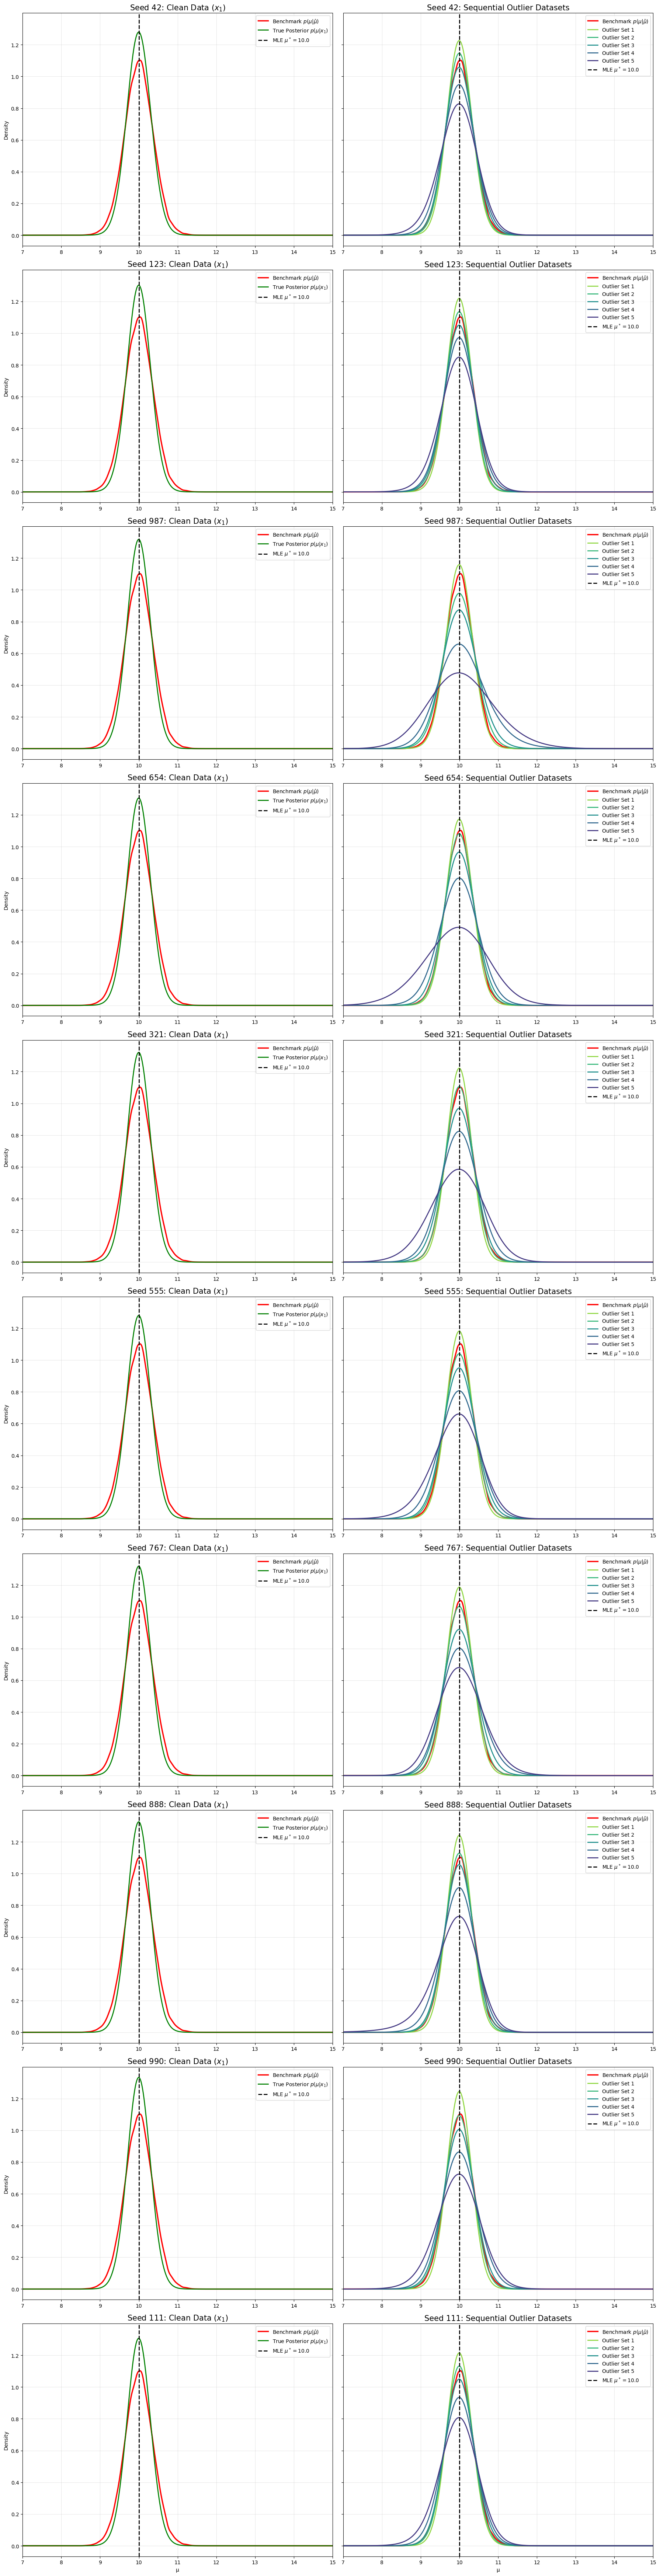

In [10]:
an.plot_all_runs_posterior_comparison(
    all_runs_posteriors=all_runs_posteriors,
    mu_grid=mu_grid_main,
    benchmark_posterior=benchmark_posterior,
    params=params,
    save_path=None
)


--- Visualizing Posteriors Grouped by Outlier Count ---


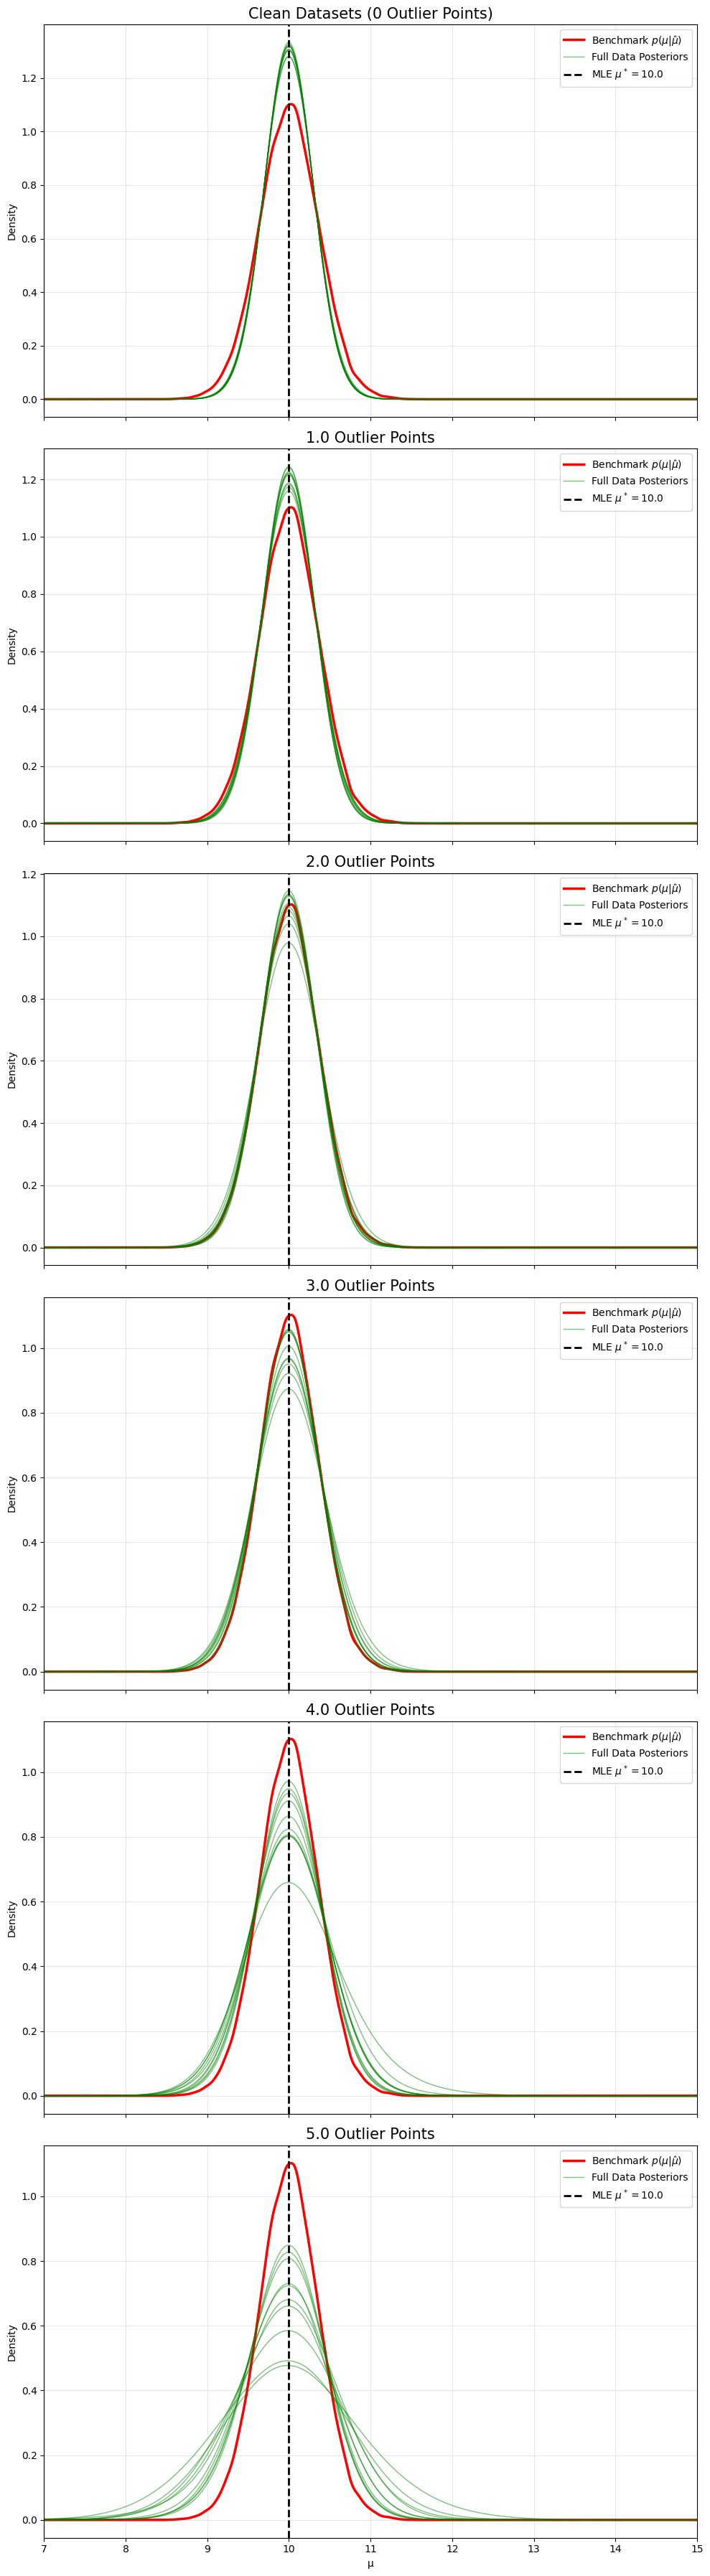

In [11]:
an.plot_outlier_wise_posterior_comparison(
    all_runs_posteriors=all_runs_posteriors,
    mu_grid=mu_grid_main,
    benchmark_posterior=benchmark_posterior,
    params=params,
    save_path=None
)

In [12]:
import numpy as np

# --- 6. Generate Posterior Samples via Inverse Transform Sampling ---
print("\n--- Generating Posterior Samples (μ) via Inverse Transform Sampling ---")

# This dictionary will store the sampled chains for all runs
all_runs_posterior_chains = {}
num_samples = params['num_iterations_T'] # e.g., 10000 samples per chain

# --- First, sample from the benchmark posterior ---
print("Sampling from benchmark posterior...")
# Calculate the CDF from the PDF
benchmark_cdf = np.cumsum(benchmark_posterior)
benchmark_cdf /= benchmark_cdf[-1] # Normalize to ensure it ends at 1
# Generate uniform random numbers
uniform_samples = np.random.rand(num_samples)
# Map uniform samples to mu_grid values via the inverse CDF
benchmark_mu_chain = np.interp(uniform_samples, benchmark_cdf, mu_grid_main)

# --- Next, sample from all analytical posteriors for each run ---
for seed, posteriors_for_this_run in all_runs_posteriors.items():
    print(f"Sampling for seed: {seed}...")
    chains_for_this_run = []
    for posterior_density in posteriors_for_this_run:
        cdf = np.cumsum(posterior_density)
        cdf /= cdf[-1] # Normalize
        uniform_samples = np.random.rand(num_samples)
        mu_chain = np.interp(uniform_samples, cdf, mu_grid_main)
        chains_for_this_run.append(mu_chain)
    all_runs_posterior_chains[seed] = chains_for_this_run

print("\nAll posterior chains (μ) have been generated successfully.")


--- Generating Posterior Samples (μ) via Inverse Transform Sampling ---
Sampling from benchmark posterior...
Sampling for seed: 42...
Sampling for seed: 123...
Sampling for seed: 987...
Sampling for seed: 654...
Sampling for seed: 321...
Sampling for seed: 555...
Sampling for seed: 767...
Sampling for seed: 888...
Sampling for seed: 990...
Sampling for seed: 111...

All posterior chains (μ) have been generated successfully.


In [13]:
# --- 7. Generate Posterior Predictive Distributions (x) ---
print("\n--- Generating Posterior Predictive Distributions (x) ---")

# This dictionary will store the final predictive chains for x
all_runs_predictive_chains = {}

# Model parameters
k = params['k']
scale = 1
m = params['m']

# --- First, generate the predictive chain from the benchmark's mu samples ---
print("Generating predictive chain from benchmark posterior...")
predictive_datasets_from_benchmark = [stats.t.rvs(df=k, loc=mu, scale=scale, size=m) for mu in benchmark_mu_chain]
x_pred_from_benchmark = np.array(predictive_datasets_from_benchmark).flatten()

# --- Next, generate predictive chains for each full dataset posterior ---
for seed, mu_chains_for_this_run in all_runs_posterior_chains.items():
    print(f"Generating predictive chains for seed: {seed}...")
    predictive_chains_for_this_run = []
    for mu_chain in mu_chains_for_this_run:
        predictive_datasets = [stats.t.rvs(df=k, loc=mu, scale=scale, size=m) for mu in mu_chain]
        x_pred = np.array(predictive_datasets).flatten()
        predictive_chains_for_this_run.append(x_pred)
    all_runs_predictive_chains[seed] = predictive_chains_for_this_run

print("\nAll posterior predictive chains (x) have been generated successfully.")


--- Generating Posterior Predictive Distributions (x) ---
Generating predictive chain from benchmark posterior...
Generating predictive chains for seed: 42...
Generating predictive chains for seed: 123...
Generating predictive chains for seed: 987...
Generating predictive chains for seed: 654...
Generating predictive chains for seed: 321...
Generating predictive chains for seed: 555...
Generating predictive chains for seed: 767...
Generating predictive chains for seed: 888...
Generating predictive chains for seed: 990...
Generating predictive chains for seed: 111...

All posterior predictive chains (x) have been generated successfully.



--- Visualizing All Posterior Predictive Distributions Across All Runs ---
Upper threshold L1 (99.5%) = 14.03
Lower threshold L2 (0.5%) = 5.97


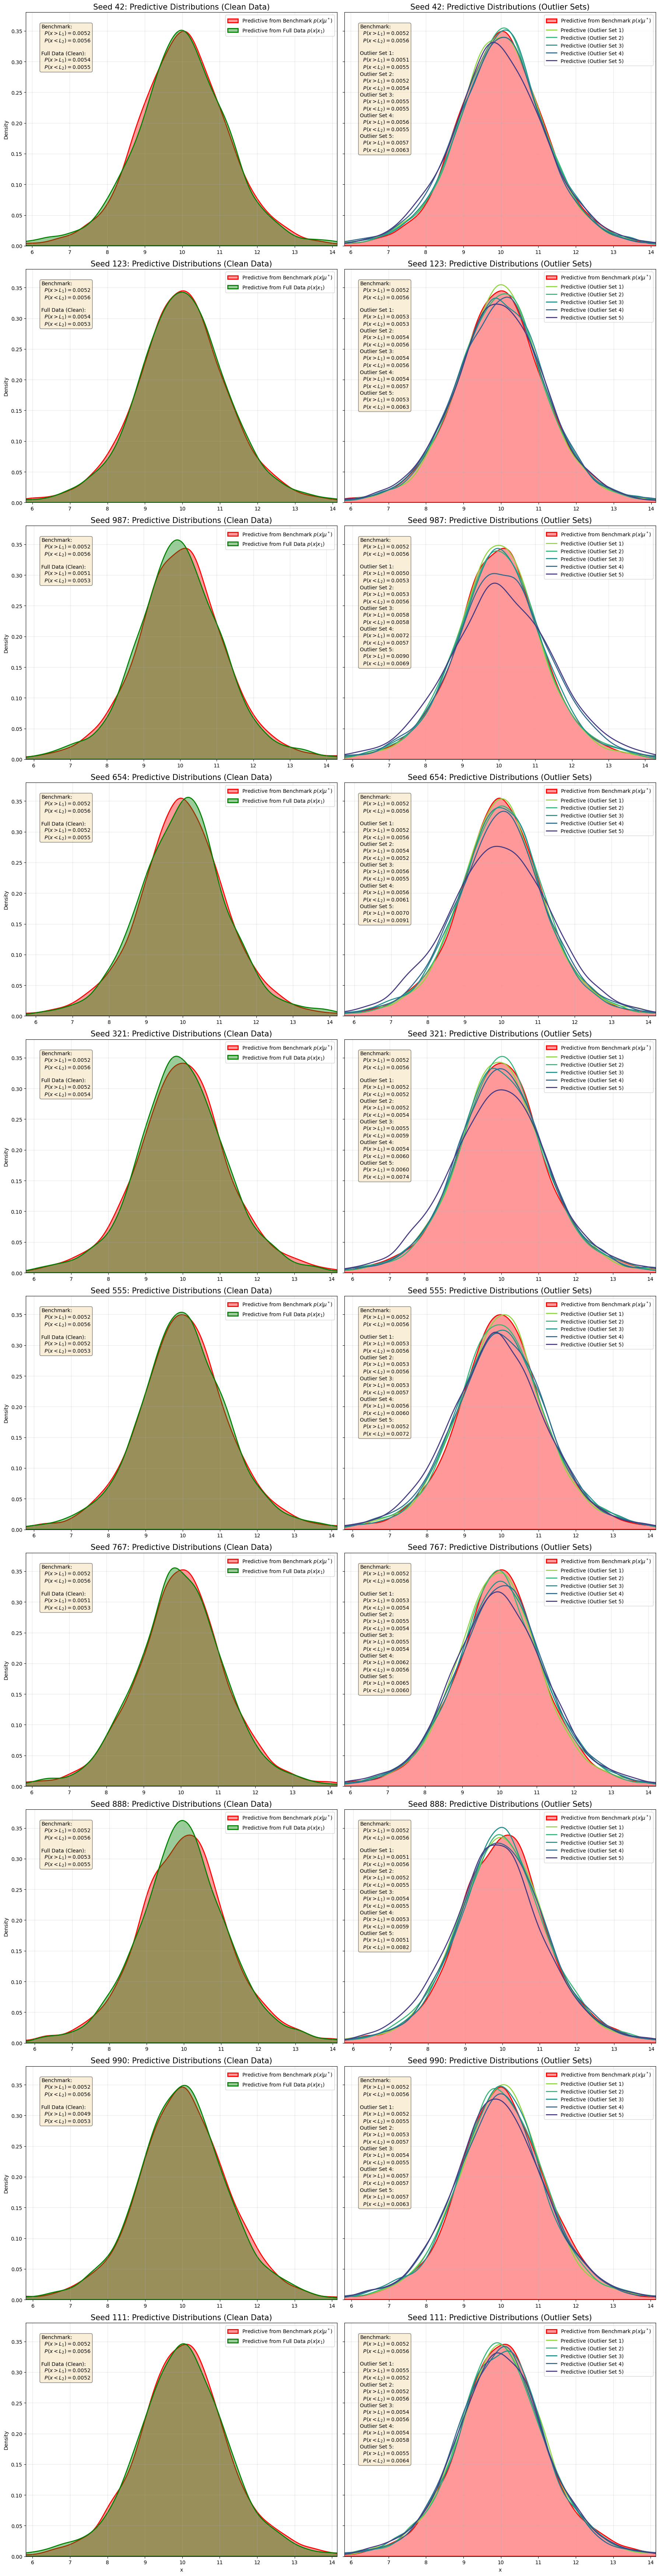

In [14]:
# This new function will create the plot you need.
# Make sure it is defined in your analysis_functions.py file.
an.plot_all_runs_predictive_comparison(
    all_runs_predictive_chains=all_runs_predictive_chains,
    x_pred_from_benchmark=x_pred_from_benchmark,
    params=params,
    save_path=None
)



--- Visualizing Predictive Distributions Grouped by Outlier Count ---


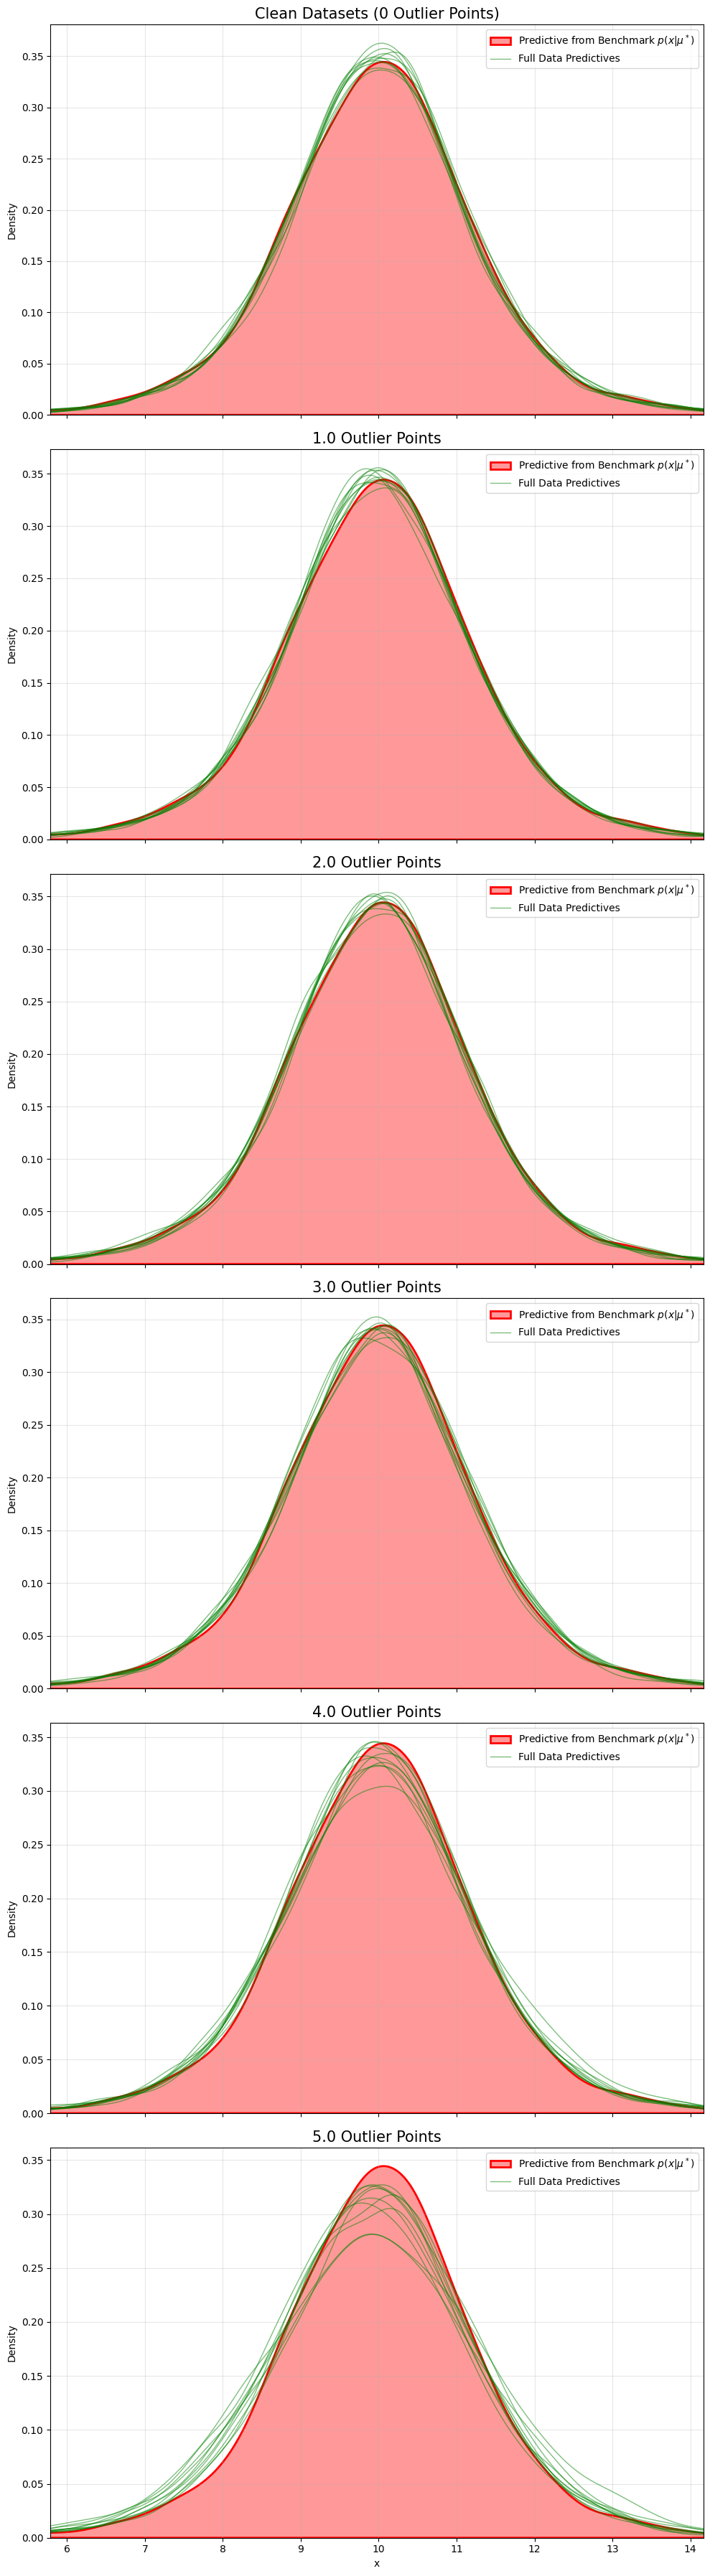

In [15]:
an.plot_outlier_wise_predictive_comparison(
    all_runs_predictive_chains=all_runs_predictive_chains,
    x_pred_from_benchmark=x_pred_from_benchmark,
    params=params,
    save_path=None
)
